# Tuned transport rules in the stochastic model of transport

This notebook contains some simulations to look at the tradeoff between speed and precision for a cable with a finite number of particles. The story is essentially the same as the deterministic model (figures shown in the paper). The error and speed of transport follow similar tradeoff curves, ***on average***, for various numbers of particles. This is an expected result (see *Methods* section of the paper for a stochastic interpretation of the mass-action model).

In [1]:
from __future__ import division
import numpy as np
import pylab as plt
%matplotlib inline

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

N = 100 # number of compartments

def get_probs(n_syn,n_particles,timescale,bias,syn_loc):
    """Calculates transition probabilities for each position"""
    # Calculate target profile, y
    if syn_loc is None: syn_loc = np.linspace(0.1,0.9,n_syn)
    x = np.linspace(0,1,N)
    y = np.zeros(N)
    for i in syn_loc:
        y += 0.5*np.exp(-abs(x - x[int(i*N)])*100)
    
    # normalize target profile to integrate to n_particles
    y /= n_syn
    y *= n_particles
    
    # detachment probabilities
    p_c = y/timescale
    
    # movement probabilities rates, constrain so that a+b = 1
    p_a = np.linspace(0.5+bias,0.5,N) # probability of anterograde movement
    # probability of retrograde movement is 1-p_a
    
    # transition probabilities
    P = np.zeros((2,N))
    P[0,:] = p_a
    P[1,:] = p_c
    
    return P,y

def run_sim(n_syn,n_particles,timescale=1e-5,bias=0.0,syn_loc=None):
    P,y = get_probs(n_syn,n_particles,timescale,bias,syn_loc)
    
    # initial positions of particles (all start in soma)
    u = np.zeros(n_particles,int)
    
    # flag each particle as attached or detached
    attached_particles = range(n_particles)
    
    # simulation
    while len(attached_particles)>0:
        for i,n in enumerate(attached_particles):
            pos = u[n]
            
            # Check if the particle detaches
            if np.random.rand()<P[1,pos]:
                attached_particles.pop(i)
                continue
            
            # Move the particle
            if np.random.rand()<P[0,pos] and u[n]<(N-1):
                u[n] += 1 # anterograde movement
            elif u[n]>0:
                u[n] -= 1 # retrograde movement
                
    
    # return final distribution
    return u,y

### Slow detachment

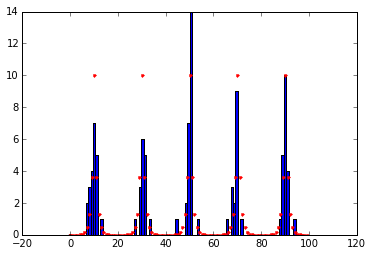

In [2]:
u,y = run_sim(5,100,timescale=1e5)
plt.hist(u,bins=N,range=(-0.5,N+0.5))
plt.plot(y,'.r')
plt.show()

### Fast detachment produces proximal bias

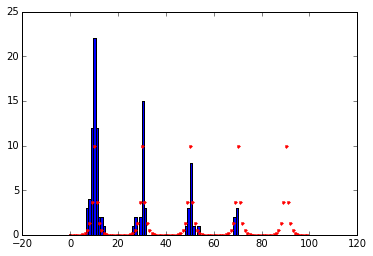

In [3]:
u,y = run_sim(5,100,timescale=1e3)
plt.hist(u,bins=N,range=(-0.5,N+0.5))
plt.plot(y,'.r')
plt.show()

### Fast detachment, with tuned anterograde transport bias

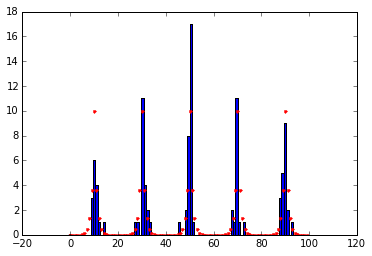

In [4]:
u,y = run_sim(5,100,timescale=1e3,bias=0.05)
plt.hist(u,bins=N,range=(-0.5,N+0.5))
plt.plot(y,'.r')
plt.show()

In [5]:
def tradeoff_curve(n_particles,nreplicates):
    timescales = np.logspace(1.5,4,8)
    biases = [0.0,0.05]
    err = np.empty((len(timescales),len(biases),nreplicates))

    plt.figure()
    for (i,ts) in enumerate(timescales):
        for (j,b) in enumerate(biases):
            for r in range(nreplicates):
                u,y = run_sim(5,n_particles,timescale=ts,bias=b)
                n,bins = np.histogram(u,bins=N,range=(-0.5,N+0.5))
                err[i,j,r] = np.mean((n-y)**2)

    avg_err = np.mean(err,axis=2)
    plt.plot(timescales,avg_err[:,0],'b')
    plt.plot(timescales,avg_err[:,1],'r')
    plt.plot(timescales,err[:,0,:],'.b')
    plt.plot(timescales,err[:,1,:],'.r')
    plt.xscale('log'), plt.xlim(10,2e4),plt.legend(('bias = 0','bias= 0.05'))
    plt.xlabel('detachment timescale'),plt.ylabel('mean square error')
    plt.title(str(n_particles)+' particles')
    plt.show()

### Tradeoff curves -- 100 particles

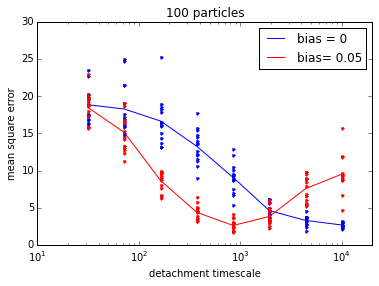

In [6]:
tradeoff_curve(100,15)

### Tradeoff curves -- 50 particles

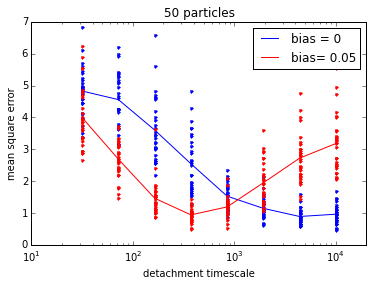

In [7]:
tradeoff_curve(50,30)

### Tradeoff curves -- 20 particles

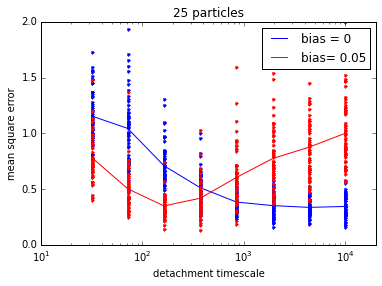

In [8]:
tradeoff_curve(25,60)